# **Salary Prediction**
In this notebook, I practice my data preprocessing skills buy most importantly my Natural Language Processing skills.<br>
I was inspired by the [YSDA NLP course](https://github.com/yandexdataschool/nlp_course/tree/2024) and I decided to build such system myself, not relying on Yandexoid code but learn by building, through trial and error.<br>
Let's predict YOUR salary!<br>
<img src="https://external-preview.redd.it/F6s6chz1GKo4sjwxCxx-kUWpmiqZvZrtuk51ZvcvZ7s.jpg?auto=webp&s=23c573d580257b2388ac27d768d2543c40decdb4" width=20%>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from tqdm import tqdm

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
df = pd.read_csv("Train_rev1.zip", compression="zip")
df.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


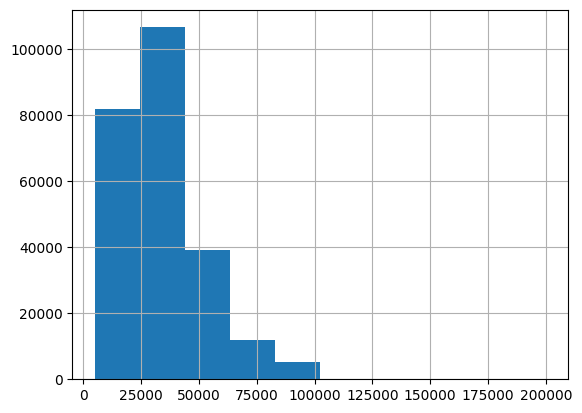

In [4]:
df["SalaryNormalized"].hist();  # Saray frequency

Okay, as we can see our target is skewed.<br>
Sadly, most of the people earn low-mid level salaries.<br>
This is not only a social problem, but also a data scientist headache, because we need to fix this inaquality!

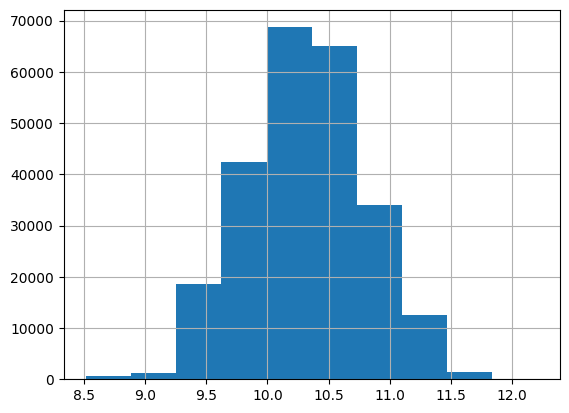

In [5]:
# Log-transform of the data
df["SalaryNormalized"] = np.log(df["SalaryNormalized"])
df["SalaryNormalized"].hist();  # Congrats! Now you earn log-dollars!

But how do I know my actual salary? I don't want to live in the world of log dollars!<br>
No worries, exp does the biz!<br>
Now let's preprocess text data

In [6]:
# Count word frequency

# Replace rare words with UNK

# Train Word2Vec

# Extract batches of text and convert into embeddings

In [7]:
tokenizer = WordPunctTokenizer()

df["Title"] = df["Title"].apply(lambda x: " ".join(tokenizer.tokenize(str(x))).lower())
df["FullDescription"] = df["FullDescription"].apply(lambda x: " ".join(tokenizer.tokenize(str(x))).lower())

In [8]:
df.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,engineering systems analyst,engineering systems analyst dorking surrey sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,10.126631,cv-library.co.uk
1,12612830,stress engineer glasgow,stress engineer glasgow salary **** to **** we...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,10.308953,cv-library.co.uk
2,12612844,modelling and simulation analyst,mathematical modeller / simulation analyst / o...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,10.308953,cv-library.co.uk
3,12613049,engineering systems analyst / mathematical mod...,engineering systems analyst / mathematical mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,10.221941,cv-library.co.uk
4,12613647,"pioneer , miser engineering systems analyst","pioneer , miser engineering systems analyst do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,10.126631,cv-library.co.uk


In [9]:
word_counts = Counter()

for i in range(df.shape[0]):
  for word in df.loc[i, "Title"].split():
    word_counts[word] += 1


for i in range(df.shape[0]):
  for word in df.loc[i, "FullDescription"].split():
    word_counts[word] += 1

In [10]:
word_counts["engineer"]

94623

In [11]:
vocab = ["UNK", "PAD"] + [t for t, c in word_counts.items() if c >= 10]
vocab[:5]

['UNK', 'PAD', 'engineering', 'systems', 'analyst']

In [12]:
len(vocab)

34158

In [13]:
stoi = {s:i for i, s in enumerate(vocab)}
stoi["engineering"]

2

In [14]:
def encode_text(text):
  res = [stoi.get(word, 0) for word in text.split()]
  return res

In [15]:
encode_text("Hello there people and engineers")

[0, 12657, 1841, 9, 62]

In [16]:
companies = set(df["Company"])
ctoi = {c:i for i, c in enumerate(companies)} # Company to index (fuck this is stupid)
df["Company"] = df["Company"].apply(lambda x: ctoi[x])

Shape of embedding with batching (yep, we'll split data in batches) should be (B, L, N); B-batch size; L-length of sequence; N-embedding dim.<br>
This is a big problem, because we have different lenghts.
We definitely should pad it and form batches.<br>
But batch should be packed with text embedding and cat feature encoding)

In [17]:
def get_batch(start_idx, batch_size=3, max_len=10):
    titles = df.loc[start_idx:start_idx+batch_size-1, "Title"]
    descs = df.loc[start_idx:start_idx+batch_size-1, "FullDescription"]
    companies = df.loc[start_idx:start_idx+batch_size-1, "Company"]

    titles_mat = np.full((batch_size, max_len), 1)  # PAD token
    descs_mat = np.full((batch_size, max_len), 1)   # PAD token

    titles_enc = titles.apply(lambda x: [stoi.get(w, 0) for w in x.split()])
    descs_enc = descs.apply(lambda x: [stoi.get(w, 0) for w in x.split()])

    for j in range(batch_size):
        stop_j = min(len(titles_enc.iloc[j]), max_len)
        titles_mat[j][:stop_j] = titles_enc.iloc[j][:stop_j]

    for j in range(batch_size):
        stop_j = min(len(descs_enc.iloc[j]), max_len)
        descs_mat[j][:stop_j] = descs_enc.iloc[j][:stop_j]

    return torch.tensor(titles_mat), torch.tensor(descs_mat), torch.tensor(companies.values)

In [18]:
titles_batch, descs_batch, companies_batch = get_batch(0)
titles_batch.shape, descs_batch.shape, companies_batch.shape

(torch.Size([3, 10]), torch.Size([3, 10]), torch.Size([3]))

In [19]:
titles_batch, descs_batch, companies_batch = get_batch(1)
titles_batch.shape, descs_batch.shape, companies_batch.shape

(torch.Size([3, 10]), torch.Size([3, 10]), torch.Size([3]))

In [20]:
companies_batch

tensor([14237, 14237, 14237])

In [21]:
emb_companies_test = nn.Embedding(len(companies)-1, 16)
emb_companies_test(companies_batch).shape

torch.Size([3, 16])

In [22]:
emb_test = nn.Embedding(len(vocab)-1, 5)
emb_test(titles_batch).shape

torch.Size([3, 10, 5])

Okay, things got a bit messy (50/50 chance of fixing this shi)<br>
But now everything is super good because we are building model and finally training it!

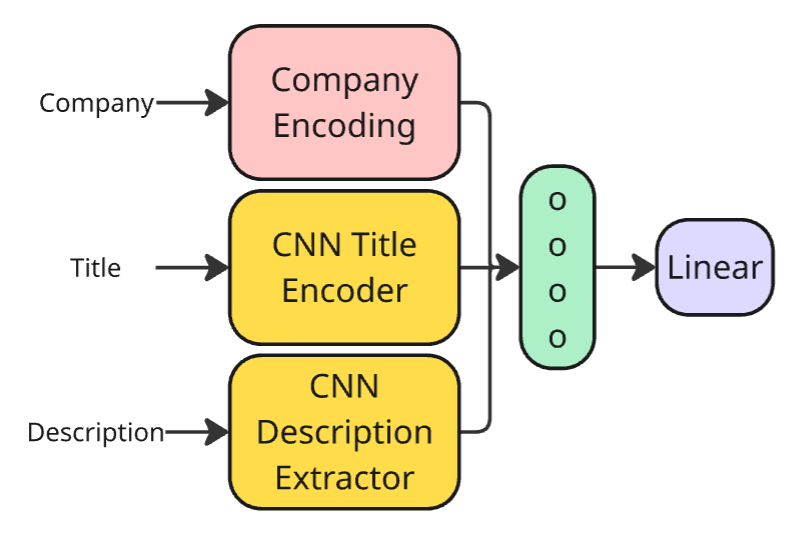

In [23]:
df["FullDescription"].head()

,FullDescription
0,engineering systems analyst dorking surrey sal...
1,stress engineer glasgow salary **** to **** we...
2,mathematical modeller / simulation analyst / o...
3,engineering systems analyst / mathematical mod...
4,"pioneer , miser engineering systems analyst do..."


In [24]:
!pip install gensim

In [34]:
from gensim.models import Word2Vec
model = Word2Vec(df["FullDescription"].apply(lambda x: x.split()),
                 vector_size=512,      # embedding vector size
                 min_count=5,  # consider words that occured at least 5 times
                 window=5)

In [35]:
model.wv.most_similar("engineer")

[('technician', 0.6410525441169739),
 ('engineers', 0.5921123623847961),
 ('draughtsman', 0.5321414470672607),
 ('analyst', 0.5320540070533752),
 ('developer', 0.5251156091690063),
 ('draughtsperson', 0.5217775106430054),
 ('estimator', 0.5207532644271851),
 ('tester', 0.5191301703453064),
 ('fitter', 0.5086554288864136),
 ('inspector', 0.49602964520454407)]

In [39]:
word_vectors = model.wv.vectors
weights = torch.FloatTensor(word_vectors)

In [40]:
class SalaryPredictor(nn.Module):
  def __init__(self, comp_size, vocab_size, comp_emb_dim):
    super().__init__()
    self.comp_emb = nn.Embedding(comp_size, comp_emb_dim)
    self.word_emb = nn.Embedding.from_pretrained(weights, freeze=False)

    self.title_enc = nn.Sequential(
        nn.Conv1d(512, 64, kernel_size=3),  # 8 trigrams
        nn.ReLU(),
        nn.Conv1d(64, 128, kernel_size=3)  # 6 something-grams?
    )

    self.desc_enc = nn.Sequential(
        nn.Conv1d(512, 64, kernel_size=3),
        nn.ReLU(),
        nn.Conv1d(64, 128, kernel_size=3)
    )

    self.final = nn.Sequential(
        nn.Linear(256+comp_emb_dim, 128),
        nn.ReLU(),
        nn.Linear(128, 1)
    )

  def forward(self, title_batch, desc_batch, comp_batch):
    # Title batch has a shape of (B, L, N)
    # N is the embedding dim and number of channels
    # But torch requires it to be earlier
    title_batch = self.word_emb(title_batch)
    desc_batch = self.word_emb(desc_batch)

    # print(title_batch.dtype, desc_batch.dtype)

    title_batch = title_batch.permute(0, 2, 1)  # (B, N, L)
    desc_batch = desc_batch.permute(0, 2, 1)  # (B, N, L)

    title_encs = self.title_enc(title_batch)  # (B, 128, 6)
    desc_encs = self.desc_enc(desc_batch)  # (B, 128, 6)

    # print(title_encs.dtype, desc_encs.dtype)


    # Global max pooling
    title_vecs = torch.max(title_encs, dim=-1).values  # (B, 128) representation
    desc_vecs = torch.max(desc_encs, dim=-1).values  # (B, 128) representation

    # print(title_vecs.dtype, desc_vecs.dtype)

    companies_vecs = self.comp_emb(comp_batch)  # (B, comp_emb_dim)
    enc = torch.cat([title_vecs, desc_vecs, companies_vecs], dim=1)

    # Final layers
    result = self.final(enc)  # (B, 1)
    return result

In [44]:
model = SalaryPredictor(len(companies), len(vocab), 10).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [45]:
targets = torch.tensor(df["SalaryNormalized"]).to(device).to(torch.float32)
targets[:6]

tensor([10.1266, 10.3090, 10.3090, 10.2219, 10.1266, 10.1266], device='cuda:0')

In [46]:
EPOCHS = 2
batch_size = 6

for epoch in range(EPOCHS):
  for i in tqdm(range(df.shape[0]-7)):
    titles_batch, descs_batch, comps_batch = get_batch(i, batch_size, max_len=12)
    targets_batch = targets[i:i+batch_size].unsqueeze(1)
    titles_batch = titles_batch.to(device)
    descs_batch = descs_batch.to(device)
    comps_batch = comps_batch.to(device)

    results = model(titles_batch, descs_batch, comps_batch)
    loss = loss_fn(results, targets_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 50000 == 0:
      print(f"{i}: {loss.item()}")

  0%|          | 12/244761 [00:00<1:07:39, 60.29it/s]

0: 102.16111755371094


 20%|██        | 50010/244761 [10:29<41:25, 78.36it/s]

50000: 0.0959431529045105


 41%|████      | 100011/244761 [20:58<29:47, 80.99it/s]

100000: 0.02807956002652645


 61%|██████▏   | 150012/244761 [31:26<19:39, 80.35it/s]

150000: 0.027174796909093857


 82%|████████▏ | 200017/244761 [41:58<09:18, 80.09it/s]

200000: 0.06269191205501556


  0%|          | 18/244761 [00:00<49:38, 82.16it/s]

0: 0.01657142862677574


 20%|██        | 50014/244761 [10:26<40:09, 80.82it/s]

50000: 0.11730541288852692


 41%|████      | 100011/244761 [20:50<29:54, 80.66it/s]

100000: 0.03483239933848381


 61%|██████▏   | 150014/244761 [31:13<19:33, 80.76it/s]

150000: 0.033239830285310745


 82%|████████▏ | 200015/244761 [41:42<09:10, 81.29it/s]

200000: 0.053411372005939484


100%|██████████| 244761/244761 [50:59<00:00, 79.99it/s]


In [47]:
df.shape[0]

244768

In [65]:
def predict(title, description, company):
  if len(title.split()) < 12:
    title += " PAD " * (12 - len(title.split()))

  if len(description.split()) < 12:
    description += " PAD " * (12 - len(description.split()))

  title = [stoi.get(w.lower(), 1) for w in title.split()]
  desc = [stoi.get(w.lower(), 1) for w in description.split()]

  title = torch.tensor(title).unsqueeze(0).to(device)
  desc = torch.tensor(desc).unsqueeze(0).to(device)
  comp = torch.tensor([ctoi[company]]).to(device)

  model.eval()
  pred = model(title, desc, comp)

  return f"{torch.exp(pred).item()}$"

In [66]:
predict("Junior Deep Learning engineer", "PyTorch , TensorFlow , OpenCV", list(companies)[0])

'31698.39453125$'

In [68]:
predict("Junior farmer", "combine driver , driver license , hard working", list(companies)[0])

'25889.197265625$'

In [69]:
title = "Chief Quantum Architect & Interstellar AI developer Deep Learning"
description = """
AI engineer software AI programmer python java c++ c physics bachelor at MIT
applied math professor bank finance money rich effective smart clever communicative kind
"""

In [70]:
predict(title, description, list(companies)[101])

'31698.39453125$'

In [64]:
stoi["kind"]

12690

# It works but it's fucking garbage.